<h3> Overview </h3>

- We will work with the datasets with transformed (more Gaussian) features.
- My rough sketches have shown that all models perform too poorly when we attempt to classify into five quality labels.
- So we will work with three quality labels. 
- The two datasets we will work with are: 
- white_wine_trans_3Q
- red_wine_trans_3Q
- Our EDA showed that chemical properties predict quality in a far different manner depending on the wine type. So we will create separate models for the white and red wine. 
- **The parameter tuning process was far more extensive than shown in this notebook. For the sake of saving space, I narrowed down the range of values to try during the grid search in a separate notebook.**



In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

<h3> 1) Load data </h3>

- White Wine

In [2]:
white_wine_trans_3Q = pd.read_csv('./transformed_wine_data/white_wine_trans_3Q.csv')

In [3]:
# Define X and y arrays
X_white = white_wine_trans_3Q.drop(['quality_label', 'quality', 'type'], axis = 1)
y_white = white_wine_trans_3Q['quality_label']

# Train | Test split
X_train, X_test, y_train, y_test = train_test_split(X_white, y_white, test_size=0.3, random_state=101, stratify = y_white)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

<h2> 2) Logistic Regression </h2>

<h3> 2.1) Logsitic regression without smote </h3>

<h4> 2.1.1) Base model + parameter tuning </h4>

In [4]:
# Create base log reg model
# Default uses L2 regularisation with C = 1.
# multi_class = "ovr": do one vs rest and choose label with highest hypothesis.
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)

penalty = ['l1', 'l2']
C = np.linspace(0.001,2,10)

param_grid = {'penalty': penalty, 'C': C}

# Use GridSearchCV to tune parameters

#grid_model = RandomizedSearchCV(log_model,param_distributions=param_grid, n_iter = 10)
grid_model = GridSearchCV(log_model,param_grid=param_grid)

<h4> 2.1.2) Train model </h4>

In [5]:
grid_model.fit(scaled_X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e-03, 2.23111111e-01, 4.45222222e-01, 6.67333333e-01,
       8.89444444e-01, 1.11155556e+00, 1.33366667e+00, 1.55577778e+00,
       1.77788889e+00, 2.00000000e+00]),
                         'penalty': ['l1', 'l2']})

<h4> 2.1.3) View best parameters </h4>

In [6]:
grid_model.best_params_

{'C': 0.22311111111111112, 'penalty': 'l1'}

- Best params:
- C: 0.223
- penalty: l1

<h4> 2.1.4) Predict and view metrics </h4>

In [7]:
y_pred = grid_model.predict(scaled_X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.59      0.29      0.39       318
         low       0.64      0.59      0.61       492
      medium       0.52      0.68      0.59       660

    accuracy                           0.57      1470
   macro avg       0.58      0.52      0.53      1470
weighted avg       0.58      0.57      0.55      1470



- **macro average f1 score: 53%**
- Note, f1 micro average is just regular accuracy. 
- f1 macro average is the mean of all f1 scores. 
- We don't care about the weighted average at the moment, since we care about the f1 score for all classes equally.

In [62]:
# Save macro average f1 score
maf1_lg = 0.53

<h4> 2.1.5) Plot confusion matrix </h4>

<Figure size 512x384 with 0 Axes>

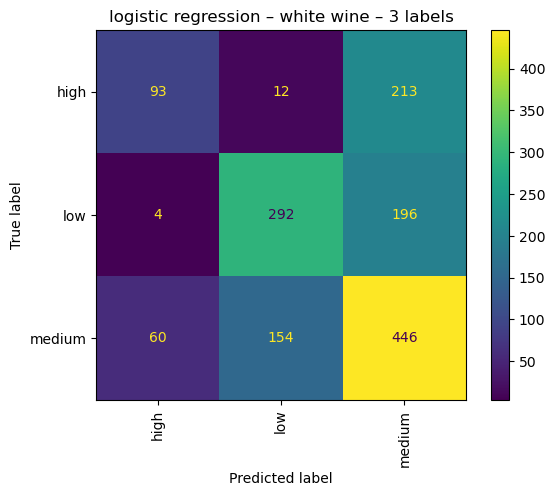

In [8]:
plt.figure(dpi = 80)
plot_confusion_matrix(grid_model, scaled_X_test, y_test)
plt.xticks(rotation = 90)
plt.title('logistic regression – white wine – 3 labels')
plt.show()

- We see the challenge of dealing with highly imbalanced datasets here.
- Recall that we have a very small number of samples in the "low" and "high" quality labels.
- The majority of the samples are in the "medium" category. 
- We thus see that the recall is especially low for the "high" and "low" quality labels.

<h3> 2.2) Logistic regression with SMOTE </h3>

- We try to address the problem of having an imbalanced dataset by undersampling / oversampling with SMOTE

In [10]:
# Define the number of samples to take from each quality label
under_strategy_white = {'medium': 1000, 'low': 1000, 'high': 742}
over_strategy_white = {'medium': 1000, 'low': 1000, 'high': 1000}

# first undersample using RandomUnderSampler
# then oversample using SMOTE
under_white = RandomUnderSampler(sampling_strategy = under_strategy_white)
over_white = SMOTE (sampling_strategy = over_strategy_white)

scaled_X_train_SMOTE, y_train_SMOTE = under_white.fit_resample(scaled_X_train, y_train)
scaled_X_train_SMOTE, y_train_SMOTE = over_white.fit_resample(scaled_X_train_SMOTE, y_train_SMOTE)

In [11]:
# Create base log reg model
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)

penalty = ['l1', 'l2']
C = np.linspace(0.001,100,10)

param_grid = {'penalty': penalty, 'C': C}

#grid_model = RandomizedSearchCV(log_model,param_distributions=param_grid, n_iter = 5)
grid_model = GridSearchCV(log_model,param_grid=param_grid)

In [12]:
grid_model.fit(scaled_X_train_SMOTE, y_train_SMOTE)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.0000e-03, 1.1112e+01, 2.2223e+01, 3.3334e+01, 4.4445e+01,
       5.5556e+01, 6.6667e+01, 7.7778e+01, 8.8889e+01, 1.0000e+02]),
                         'penalty': ['l1', 'l2']})

In [13]:
grid_model.best_params_

{'C': 11.111999999999998, 'penalty': 'l1'}

In [14]:
y_pred = grid_model.predict(scaled_X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.43      0.75      0.55       318
         low       0.56      0.73      0.63       492
      medium       0.56      0.23      0.33       660

    accuracy                           0.51      1470
   macro avg       0.52      0.57      0.50      1470
weighted avg       0.53      0.51      0.48      1470



- **macro average f1-score: 50%**
- Our model actually performs worse with over- and under-sampling

Text(0.5, 1.0, 'logistic regression – white wine – 3 labels')

<Figure size 512x384 with 0 Axes>

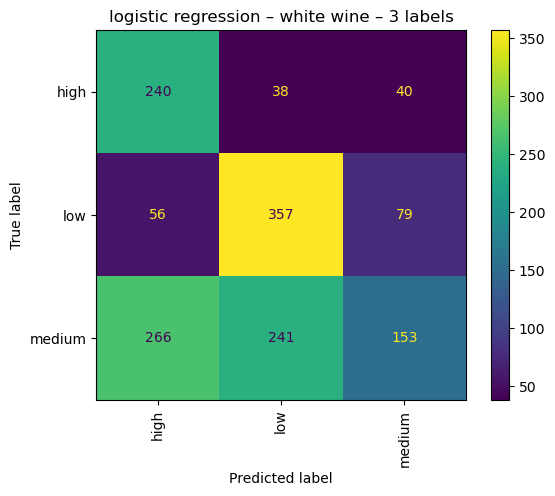

In [15]:
plt.figure(dpi = 80)
plot_confusion_matrix(grid_model, scaled_X_test, y_test)
plt.xticks(rotation = 90)
plt.title('logistic regression – white wine – 3 labels')


- Interesting that recall is now much higher for the "high" and "low" quality labels, but much lower for the "medium" quality label.
- This is precisely the reverse as when we didn't over- and under-sample

<h2> 3) Support vector machine </h2>

- We will begin by using the elbow method to check the behaviour of the training and test error for the rbf kernel

<h3> 3.1) Elbow method when varying C value </h3>

In [16]:
# rbf Kernel with various C values
C_vals = list(np.linspace(0.01, 50, 20))
test_errors = []
train_errors = []

for C in C_vals: 
    svm_model = SVC(kernel = 'rbf', C = C)
    svm_model.fit(scaled_X_train,y_train)

    y_pred_train = svm_model.predict(scaled_X_train)
    y_pred_test = svm_model.predict(scaled_X_test)

    error_train = 1 - accuracy_score (y_pred_train, y_train)
    error_test = 1 - accuracy_score (y_pred_test, y_test)
    
    train_errors.append(error_train)
    test_errors.append(error_test)

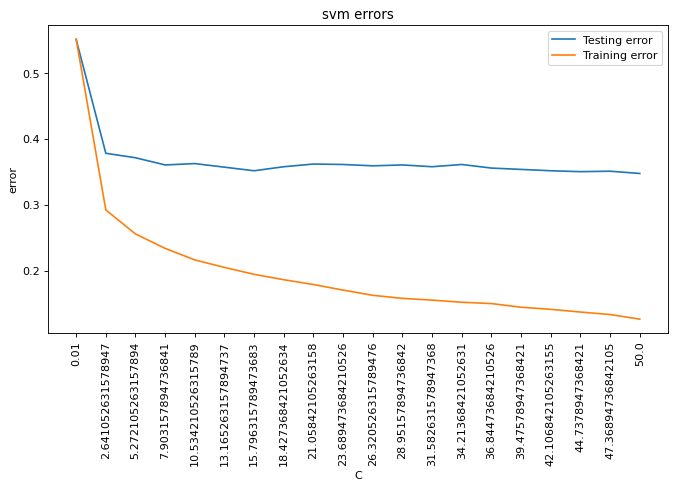

In [17]:
plt.figure(figsize = (10,5), dpi = 80)
plt.title("svm errors")
plt.plot(C_vals, test_errors, label="Testing error")
plt.plot(C_vals, train_errors, label="Training error")
plt.legend()
plt.xticks(ticks = C_vals, labels = C_vals)
plt.xticks(rotation = 90)
plt.xlabel("C")
plt.ylabel("error")
plt.show()

- elbow appears to be in the region of C = 2.6

<h3> 3.2) Elbow method while varying gamma value </h3>

In [18]:
# rbf Kernel with C = 6 and different gamma values
gamma_vals = list(np.linspace(0.01, 2, 20))
test_errors = []
train_errors = []

for gamma in gamma_vals: 
    svm_model = SVC(kernel = 'rbf', C = 6, gamma = gamma)
    svm_model.fit(scaled_X_train,y_train)

    y_pred_train = svm_model.predict(scaled_X_train)
    y_pred_test = svm_model.predict(scaled_X_test)

    error_train = 1 - accuracy_score (y_pred_train, y_train)
    error_test = 1 - accuracy_score (y_pred_test, y_test)
    
    train_errors.append(error_train)
    test_errors.append(error_test)

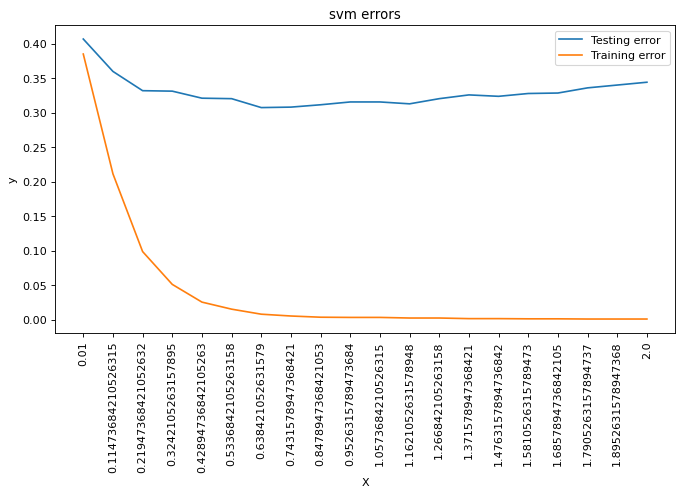

In [19]:
plt.figure(figsize = (10,5), dpi = 80)
plt.title("svm errors")
plt.plot(gamma_vals, test_errors, label="Testing error")
plt.plot(gamma_vals, train_errors, label="Training error")
plt.legend()
plt.xticks(ticks = gamma_vals, labels = gamma_vals)
plt.xticks(rotation = 90)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

<h3> 3.3) Parameter tuning with grid search </h3>

In [20]:
# Grid search 

svm = SVC()
param_grid = {'C':list(np.linspace (0.1, 15, 10)),'kernel':['linear','rbf'], 'gamma': list(np.linspace(0.01, 2, 10))}
grid = GridSearchCV(svm,param_grid)

In [21]:
grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.7555555555555558, 3.4111111111111114,
                               5.066666666666666, 6.722222222222222,
                               8.377777777777778, 10.033333333333333,
                               11.68888888888889, 13.344444444444445, 15.0],
                         'gamma': [0.01, 0.23111111111111113,
                                   0.45222222222222225, 0.6733333333333333,
                                   0.8944444444444445, 1.1155555555555556,
                                   1.3366666666666667, 1.557777777777778,
                                   1.778888888888889, 2.0],
                         'kernel': ['linear', 'rbf']})

- run time: 8m 11 s

In [22]:
grid.best_params_

{'C': 1.7555555555555558, 'gamma': 0.45222222222222225, 'kernel': 'rbf'}

- best params:
- C = 1.76
- gamma: 0.45
- kernel: rbf

In [23]:
y_pred = grid.predict(scaled_X_test)

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.72      0.59      0.65       318
         low       0.73      0.65      0.69       492
      medium       0.63      0.74      0.68       660

    accuracy                           0.68      1470
   macro avg       0.69      0.66      0.67      1470
weighted avg       0.68      0.68      0.68      1470



- **macro avg f1-score: 67%**
- Compared to logistic regression, the recall score is higher across all quality labels

In [63]:
maf1_svm = 0.67

<h3> 4) Decision tree </h3>

- No need to use scaled feature values, since DecisionTree model evaluates one value at a time

In [26]:
# Tune hyperparameters

dt = DecisionTreeClassifier()

param_grid = {'max_depth': [3, 5, 10,15,20,30,50],
              'max_leaf_nodes': [10, 30, 50, 70, 100],
              'min_samples_split': [2, 5, 10, 15, 20]}

#grid_model = RandomizedSearchCV(dt, param_distributions = param_grid, n_iter = 10)
grid_model = GridSearchCV(dt,param_grid)

In [27]:
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 10, 15, 20, 30, 50],
                         'max_leaf_nodes': [10, 30, 50, 70, 100],
                         'min_samples_split': [2, 5, 10, 15, 20]})

In [28]:
grid_model.best_params_

{'max_depth': 15, 'max_leaf_nodes': 100, 'min_samples_split': 5}

In [29]:
y_pred = grid_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.55      0.51      0.53       318
         low       0.64      0.62      0.63       492
      medium       0.56      0.59      0.58       660

    accuracy                           0.58      1470
   macro avg       0.58      0.57      0.58      1470
weighted avg       0.58      0.58      0.58      1470



- **macro average f1-score: 58%**

In [64]:
maf1_dt = 0.58

<Figure size 320x320 with 0 Axes>

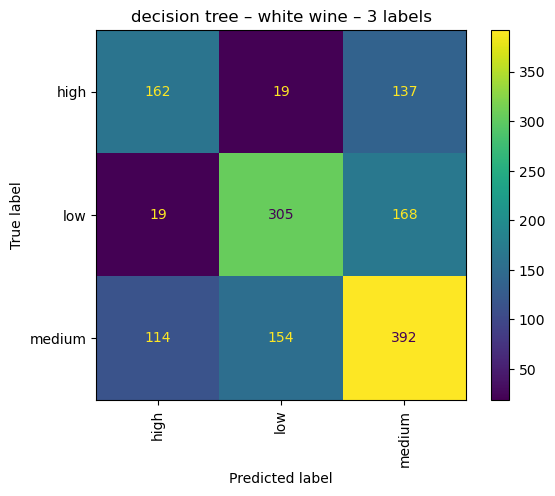

In [37]:
plt.figure(figsize = (4,4), dpi = 80)
plot_confusion_matrix(grid_model, X_test, y_test)
plt.xticks(rotation = 90)
plt.title('decision tree – white wine – 3 labels')
plt.show()

<h3> 5) Random Forest </h3>

- Again, no need to scale the features, since the RandomForest model evaluates one feature at a time.

In [40]:
# Tune hyperparameters
n_estimators=[90,110,130,150]
max_features= [2,3,4,5]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap} 

rf = RandomForestClassifier()

#grid_model = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 10)
grid_model = GridSearchCV(rf,param_grid)

In [41]:
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 5],
                         'n_estimators': [90, 110, 130, 150]})

- run time: 1m 47s

In [42]:
grid_model.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 150}

- Best parameters:
- bootstrap: True
- max_features: 2
- n_estimators: 150

In [43]:
y_pred = grid_model.predict(X_test)
print(classification_report(y_test,y_pred, labels = ['low', 'medium', 'high']))

              precision    recall  f1-score   support

         low       0.76      0.72      0.74       492
      medium       0.66      0.75      0.70       660
        high       0.76      0.61      0.68       318

    accuracy                           0.71      1470
   macro avg       0.73      0.69      0.71      1470
weighted avg       0.71      0.71      0.71      1470



- **macro average f1-score: 71%**

In [65]:
maf1_rf = 0.71

<h3> 6) K nearest neighbours (KNN) </h3>

<h4> 6.1) Elbow method to find optimal K value </h4>

In [47]:
train_error_rates = []
test_error_rates = []

for k in range(1,21):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_train = knn_model.predict(scaled_X_train)
    y_pred_test = knn_model.predict(scaled_X_test)
    
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test,y_pred_test)

    train_error_rates.append(train_error)
    test_error_rates.append(test_error)

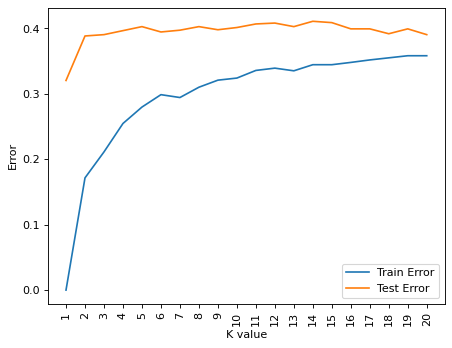

In [50]:
plt.figure(dpi = 80)
plt.plot(range(1,21),train_error_rates,label='Train Error')
plt.plot(range(1,21),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error')
plt.xlabel("K value")
plt.xticks (ticks = range(1,21), labels = range(1,21))
plt.xticks(rotation = 90)
plt.show()

- Baffling graph... 
- K = 1 gives us redundant results (chooses the sample itself)
- But how can the error keep increasing?

<h4> 6.2) Parameter tuning with GridSearchCV </h4>

In [57]:
knn = KNeighborsClassifier()

# Search from 2 onwards
k_values = list(range(2,21))
param_grid = {'n_neighbors': k_values}

#grid_model = RandomizedSearchCV(knn, param_distributions = param_grid, n_iter = 10)
grid_model = GridSearchCV(knn,param_grid)

In [58]:
grid_model.fit(scaled_X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]})

In [59]:
grid_model.best_params_

{'n_neighbors': 10}

- best parameter: n_neighbors = 10

In [60]:
y_pred = grid_model.predict(scaled_X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.52      0.57      0.54       318
         low       0.66      0.66      0.66       492
      medium       0.59      0.57      0.58       660

    accuracy                           0.60      1470
   macro avg       0.59      0.60      0.59      1470
weighted avg       0.60      0.60      0.60      1470



- **macro average f1-score: 59%**

In [66]:
maf1_knn = 0.59

<h3> 7) Comparison of macro average f1 scores </h3>

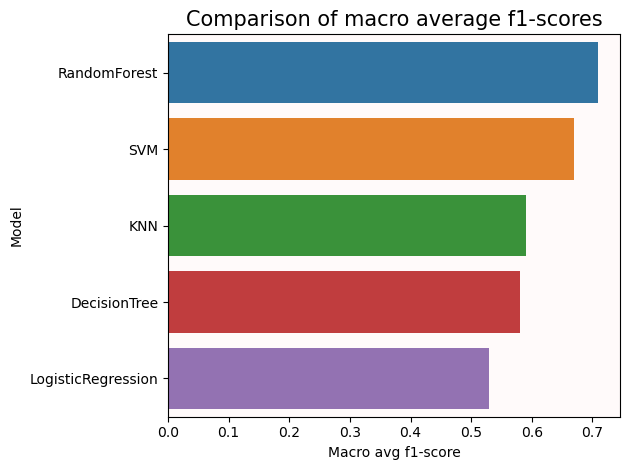

In [69]:
scores = pd.DataFrame({
    "Model":[
        "LogisticRegression",
        "SVM",
        "DecisionTree",
        "RandomForest",
        "KNN"
        ],
    "Macro avg f1-score":[
            maf1_lg,
            maf1_svm,
            maf1_dt,
            maf1_rf,
            maf1_knn
        ]
    })

scores.sort_values(
    by="Macro avg f1-score",
    ascending=False,
    inplace=True
    )
sns.barplot(
    x="Macro avg f1-score",
    y="Model",
    data = scores
    ).set_facecolor(color="snow")

plt.title("Comparison of macro average f1-scores", fontsize=15)
plt.tight_layout()
plt.show()